In [1]:
import pandas as pd
import sklearn
from sklearn import *
import numpy as np
import pickle
from utils import *
import matplotlib.pyplot as plt
import joblib

# use this to train and VALIDATE your solution
df = pd.read_csv("./quora_train_data.csv")
train_df, valid_df = sklearn.model_selection.train_test_split(df, test_size=0.05, random_state=123)
train_df = train_df.loc[~(pd.isnull(train_df.question1) | pd.isnull(train_df.question2)), :]

# Transform the training and validation datasets

In [2]:
transformer_baseline = joblib.load('transformers/baseline.joblib')
print('Loaded baseline transformer')
#X_train_bow = transformer.transform(train_df)
#X_valid_bow = transformer.transform(valid_df)

transformer = joblib.load('transformers/word2vec.joblib')
X_train_word2vec = transformer.transform(train_df)
X_valid_word2vec = transformer.transform(valid_df)
print('Transformed data with word2vec transformer')

transformer = joblib.load('transformers/cooccurrance_svd.joblib')
print('Loaded cooccurence transformer')
X_train_cooccurrence = transformer.transform(train_df)
X_valid_cooccurrence = transformer.transform(valid_df)
print('Transformed data with cooccurence transformer')

Loaded baseline transformer
Transformed data with word2vec transformer
Loaded cooccurence transformer
Transformed data with cooccurence transformer


# Computing the ROC curves for the distance metrics

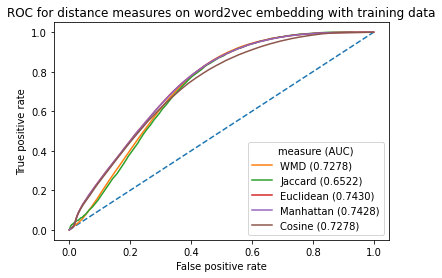

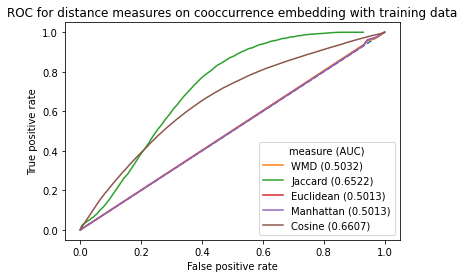

In [3]:
y_train = train_df['is_duplicate']

ROC_modes = {
    "word2vec": X_train_word2vec,
    "cooccurrence": X_train_cooccurrence
}

distances = [
    "WMD", "Jaccard", "Euclidean", "Manhattan", "Cosine"
]
    
for embedding, data in ROC_modes.items():
    plt.plot([0,1],[0,1], '--')
    
    for i, name in enumerate(distances):
        dist = data[:,-1-i]
        
        # Invert Jaccard as it is a similarity measure
        # (This is already done for cosine distance in its function)
        if name == "Jaccard":
            dist = 1 - dist
        
        # Compute the ROC curve
        roc = [tpr_fpr(p, dist, y_train) for p in np.linspace(0, dist.max(), 1000)]
        
        # Plot the ROC curve and compute AUC
        tpr, fpr = zip(*roc)
        plt.plot(fpr, tpr, label='{} ({:.4f})'.format(name, metrics.auc(fpr, tpr)))

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(f'ROC for distance measures on {embedding} embedding with training data')
    plt.legend(title='measure (AUC)')
    plt.show()

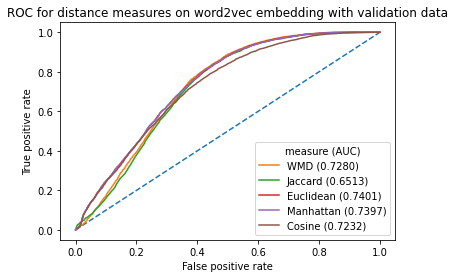

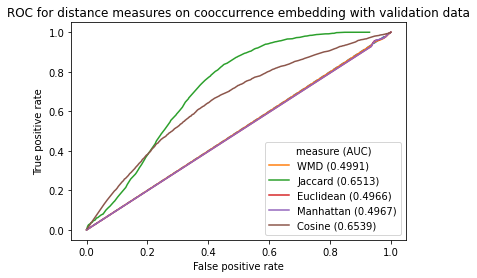

In [4]:
y_valid = valid_df['is_duplicate']

ROC_modes = {
    "word2vec": X_valid_word2vec,
    "cooccurrence": X_valid_cooccurrence
}

distances = [
    "WMD", "Jaccard", "Euclidean", "Manhattan", "Cosine"
]
    
for embedding, data in ROC_modes.items():
    plt.plot([0,1],[0,1], '--')
    
    for i, name in enumerate(distances):
        dist = data[:,-1-i]
        
        # Invert Jaccard as it is a similarity measure
        # (This is already done for cosine distance in its function)
        if name == "Jaccard":
            dist = 1 - dist
        
        # Compute the ROC curve
        roc = [tpr_fpr(p, dist, y_valid) for p in np.linspace(0, dist.max(), 1000)]
        
        # Plot the ROC curve and compute AUC
        tpr, fpr = zip(*roc)
        plt.plot(fpr, tpr, label='{} ({:.4f})'.format(name, metrics.auc(fpr, tpr)))

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(f'ROC for distance measures on {embedding} embedding with validation data')
    plt.legend(title='measure (AUC)')
    plt.show()

# Computing the ROC curves for the models

In [5]:
from sklearn.metrics import roc_curve

models = {
    "bow": [
        joblib.load('models/BoW_logistic.joblib'),
        joblib.load('models/BoW_xgboost.joblib')
    ],
    "word2vec": [
        joblib.load('models/word2vec_logistic.joblib'),
        joblib.load('models/word2vec_xgboost.joblib')
    ],
    "cooccurrence": [
        joblib.load('models/cooccurrence_logistic.joblib'),
        joblib.load('models/cooccurrence_xgboost.joblib')
    ]
}

models_names = ['Logistic Regression', 'XGBoost']

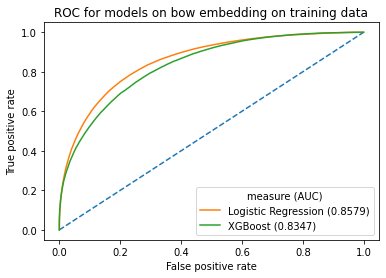

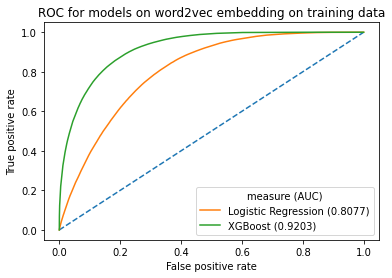

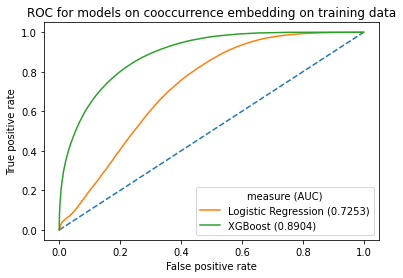

In [6]:
ROC_modes = {
    "bow": transformer_baseline.transform(train_df),
    "word2vec": X_train_word2vec,
    "cooccurrence": X_train_cooccurrence
}
    
for embedding, data in ROC_modes.items():
    plt.plot([0,1],[0,1], '--')
    
    for model, name in zip(models[embedding], models_names):
        # High probabiliy means low distance to the true class (positive class)
        positive_proba = 1 - model.predict_proba(data)[:, 1]
        
        # Compute the ROC curve
        roc = [tpr_fpr(p, positive_proba, y_train) for p in np.linspace(0, positive_proba.max(), 1000)]
        
        # Plot the ROC curve and compute AUC
        tpr, fpr = zip(*roc)
        plt.plot(fpr, tpr, label='{} ({:.4f})'.format(name, metrics.auc(fpr, tpr)))

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(f'ROC for models on {embedding} embedding on training data')
    plt.legend(title='measure (AUC)')
    plt.show()

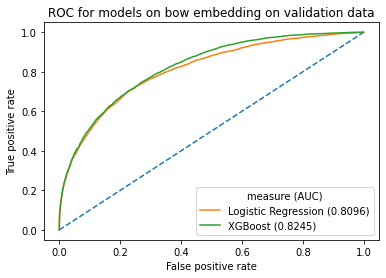

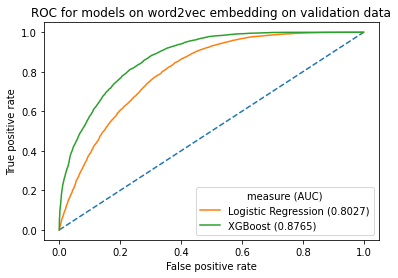

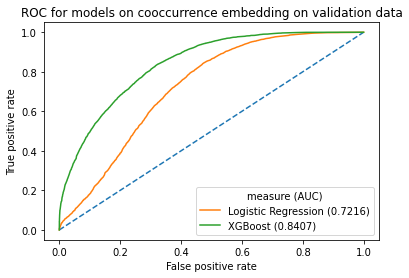

In [7]:
ROC_modes = {
    "bow": transformer_baseline.transform(valid_df),
    "word2vec": X_valid_word2vec,
    "cooccurrence": X_valid_cooccurrence
}
    
for embedding, data in ROC_modes.items():
    plt.plot([0,1],[0,1], '--')
    
    for model, name in zip(models[embedding], models_names):
        # High probabiliy means low distance to the true class (positive class)
        positive_proba = 1 - model.predict_proba(data)[:, 1]
        
        # Compute the ROC curve
        roc = [tpr_fpr(p, positive_proba, y_valid) for p in np.linspace(0, positive_proba.max(), 1000)]
        
        # Plot the ROC curve and compute AUC
        tpr, fpr = zip(*roc)
        plt.plot(fpr, tpr, label='{} ({:.4f})'.format(name, metrics.auc(fpr, tpr)))

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(f'ROC for models on {embedding} embedding on validation data')
    plt.legend(title='measure (AUC)')
    plt.show()